# GR 5221 Final Project

In [76]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [77]:
import datetime as dt
import warnings

## Section 1: Exloratory Analysis

### 1.1 Load Data

In [78]:
df =  pd.read_csv('all_stocks_5yr.csv')
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [79]:
df.columns

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'Name'], dtype='object')

### 1.2 Reframe the dataframe
- Choose company `AAL` only
- Choose column `date` and `close`

In [80]:
AAL = df[df['Name'] == 'AAL']
ALL_1 = AAL.loc[:, ['date', 'close']]
ALL_1['date'] = pd.to_datetime(ALL_1['date'], format="%Y-%m-%d")
ALL_1.head()

,date,close
0,2013-02-08,14.75
1,2013-02-11,14.46
2,2013-02-12,14.27
3,2013-02-13,14.66
4,2013-02-14,13.99


There is no null value in the dataframe.

In [81]:
ALL_1.isnull().sum()

date     0
close    0
dtype: int64

In [82]:
ALL_1.shape

(1259, 2)

### 1.3 Visualization

Text(0.5, 1.0, 'All Close Price History Of AAL')

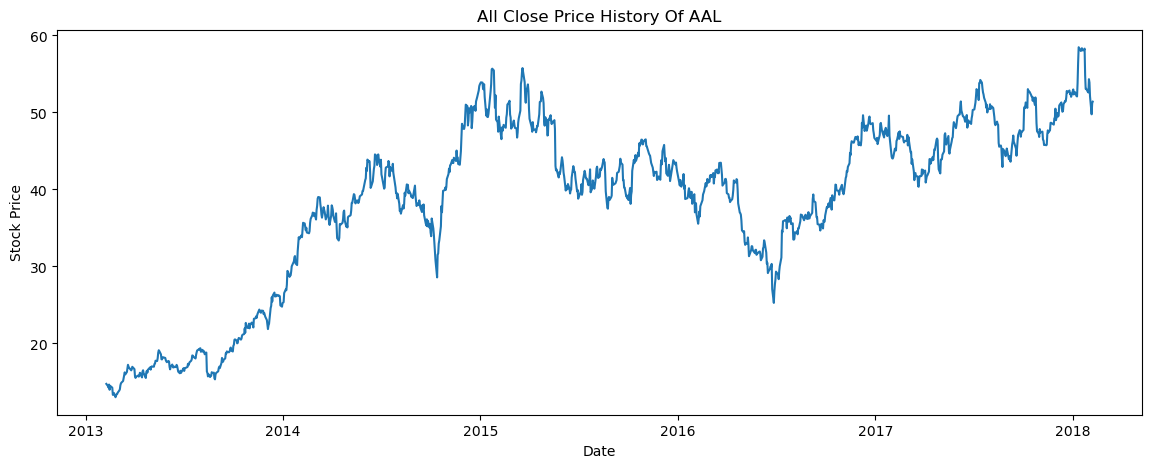

In [83]:
fig, ax = plt.subplots(figsize=(14,5))
ax.plot(ALL_1['date'], ALL_1['close'])
ax.set_xlabel("Date")
ax.set_ylabel("Stock Price")
ax.set_title("All Close Price History Of AAL")

---

#### Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

#### Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

In [84]:
result = adfuller(ALL_1['close'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.066675
p-value: 0.258124


#### p-value: 0.258124 > 0.05, we faill to reject Null hypothesis.

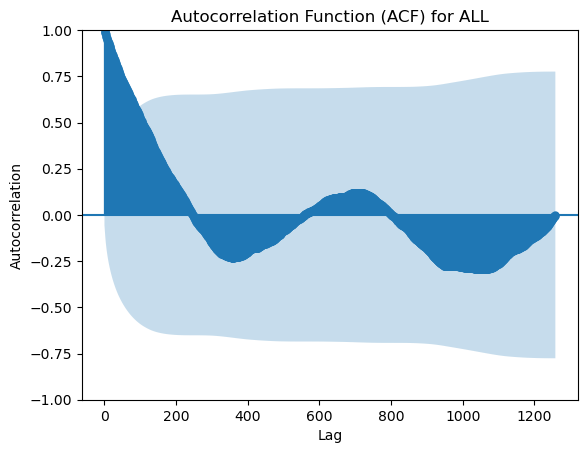

In [85]:
plot_acf(ALL_1['close'], lags=range(1, len(ALL_1['close'])))
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF) for ALL')
plt.show()

### Detrending and Seasonality

- Noticed that there's seasonality in the the data. Take period = 100.

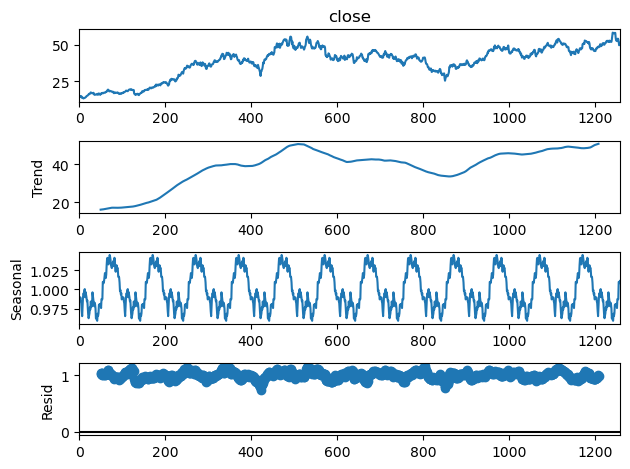

In [88]:
from statsmodels.tsa.seasonal import seasonal_decompose  
# STL 
stl = seasonal_decompose(ALL_1.close, model = 'multiplicable', period =100)
stl.plot();

When looking at time series data it’s difficult to manually extract the trend or identify the seasonality. Fortunately, we can automatically decompose a time series and helps us have a clearer view of the components as It’s easier to analyze the trend if we remove the seasonality from our data and vise versa.

In [95]:
ALL_1['deseason'] = ALL_1['close'] -stl.seasonal
ALL_1['trend'] = stl.trend.fillna(0)
ALL_1['detrend'] = ALL_1['close']-ALL_1['trend']
ALL_1['detrended_deseasoned_data'] =  ALL_1['deseason'] - ALL_1['trend']
ALL_1.head()

,date,close,deseason,trend,detrend,detrended_deseasoned_data
0,2013-02-08,14.75,13.762102,0.0,14.75,13.762102
1,2013-02-11,14.46,13.470418,0.0,14.46,13.470418
2,2013-02-12,14.27,13.281521,0.0,14.27,13.281521
3,2013-02-13,14.66,13.670376,0.0,14.66,13.670376
4,2013-02-14,13.99,13.005362,0.0,13.99,13.005362


visualize the deseason data again.

After deseasonalizing, it is harder to identify seasonality directly from the figure. We are unable to completely remove seasonality for the stock 'ALL'. 
Stock price seasonality is not a guaranteed or consistent phenomenon, and it can vary widely depending on various factors such as market conditions, global events, and company-specific factors.

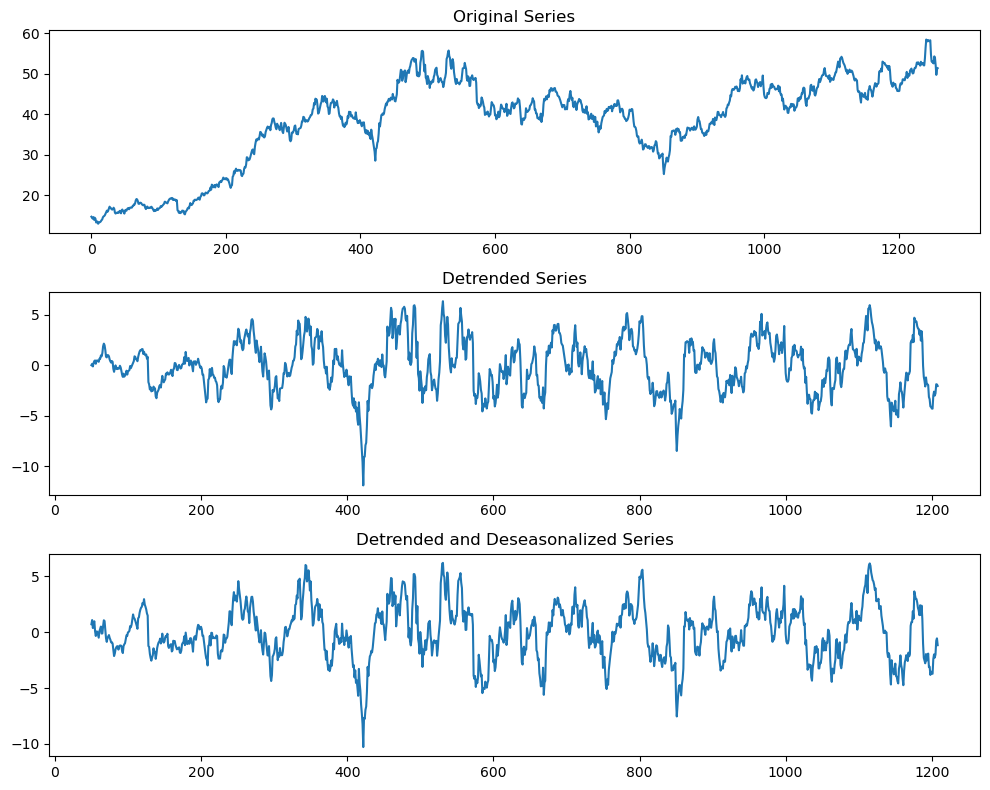

In [96]:
stl = seasonal_decompose(ALL_1['close'], model = 'additive', period =100)

# Get detrended series
detrended = ALL_1['close'] - stl.trend

# Get deseasonalized series
deseasonalized = detrended- stl.seasonal 


# Plot original, detrended, and deseasonalized series
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(10, 8))
axs[0].plot(ALL_1['close'])
axs[0].set_title('Original Series')
axs[1].plot(detrended)
axs[1].set_title('Detrended Series')
axs[2].plot(deseasonalized)
axs[2].set_title('Detrended and Deseasonalized Series')
plt.tight_layout()
plt.show()

- Detrend

Now we are going to detrend the data.

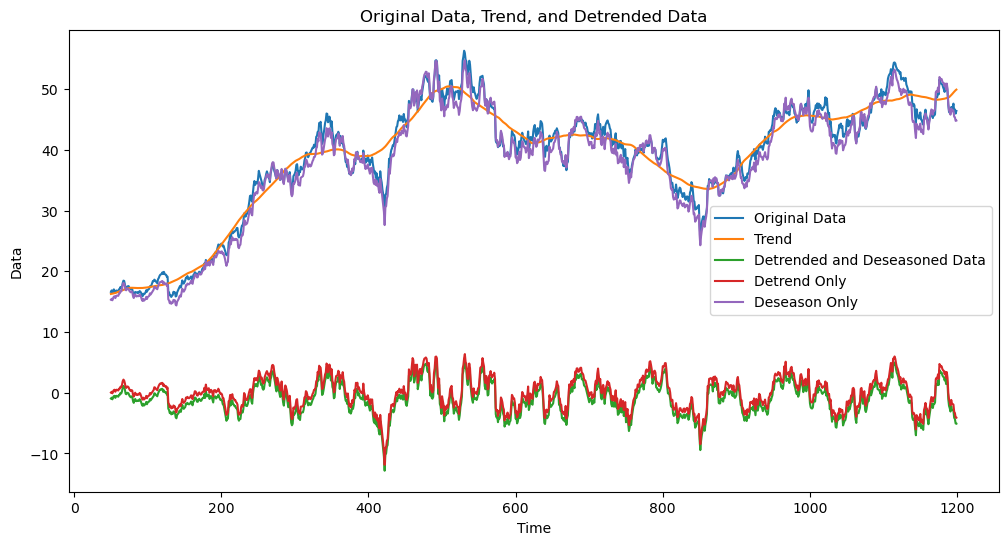

In [97]:
plt.figure(figsize=(12, 6))
plt.plot(X[50:1200], y[50:1200], label='Original Data')
plt.plot(X[50:1200], ALL_1['trend'].values[50:1200], label='Trend')
plt.plot(X[50:1200], ALL_1['detrended_deseasoned_data'].values[50:1200], label='Detrended and Deseasoned Data')
plt.plot(X[50:1200], ALL_1.detrend.values[50:1200], label = 'Detrend Only')
plt.plot(X[50:1200], ALL_1.deseason.values[50:1200], label = 'Deseason Only')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Data')
plt.title('Original Data, Trend, and Detrended Data')
plt.show()

## Section 2: Time Series Model and Modeling Process 


## AR and MA

In [78]:
from statsmodels.tsa.arima.model import ARIMA
warnings.filterwarnings("ignore")
# model1 is AR(1)
model1 = ARIMA(ALL_1.deseason, order = (1,0,0))
# model2 is MA(1)
model2 = ARIMA(ALL_1.deseason, order = (0,0,1))
model_fit1 = model1.fit()
model_fit2 = model2.fit()

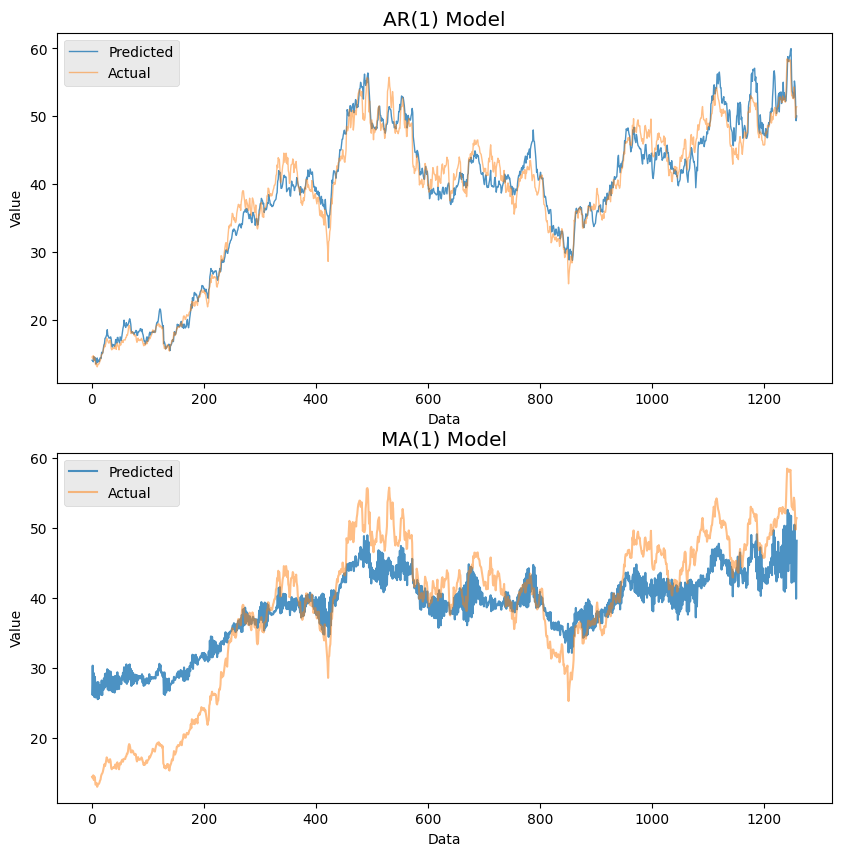

In [27]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
pred1 = model_fit1.predict()
pred2 = model_fit2.predict()
plt.style.use('ggplot')

# plot actual values and predicted values
ax1.plot(pred1[1:], label='Predicted', alpha = 0.8 ,linewidth = 1)
ax1.plot(ALL_1.close[1:], label='Actual', alpha = 0.5,linewidth = 1)
ax1.set_title('AR(1) Model')
ax1.set_xlabel('Data')
ax1.set_ylabel('Value')
ax1.legend()


ax2.plot(pred2[1:], label='Predicted', alpha = 0.8)
ax2.plot(ALL_1.close[1:], label='Actual', alpha = 0.5)
ax2.set_title('MA(1) Model')
ax2.set_xlabel('Data')
ax2.set_ylabel('Value')
ax2.legend()

plt.show()

The lower the value of the Root Mean Squared Error, the better the model is.(...)

In [28]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(ALL_1.close[1:], pred1[1:]))
rmse2 = np.sqrt(mean_squared_error(ALL_1.close[1:], pred2[1:]))
print(f'The Root Mean Squared Error for AR(1) model is {rmse}\nThe Root Mean Squared Error for MA(1) model is {rmse2}')

The Root Mean Squared Error for AR(1) model is 2.127272430291173
The Root Mean Squared Error for MA(1) model is 5.946755301435109


## ARIMA

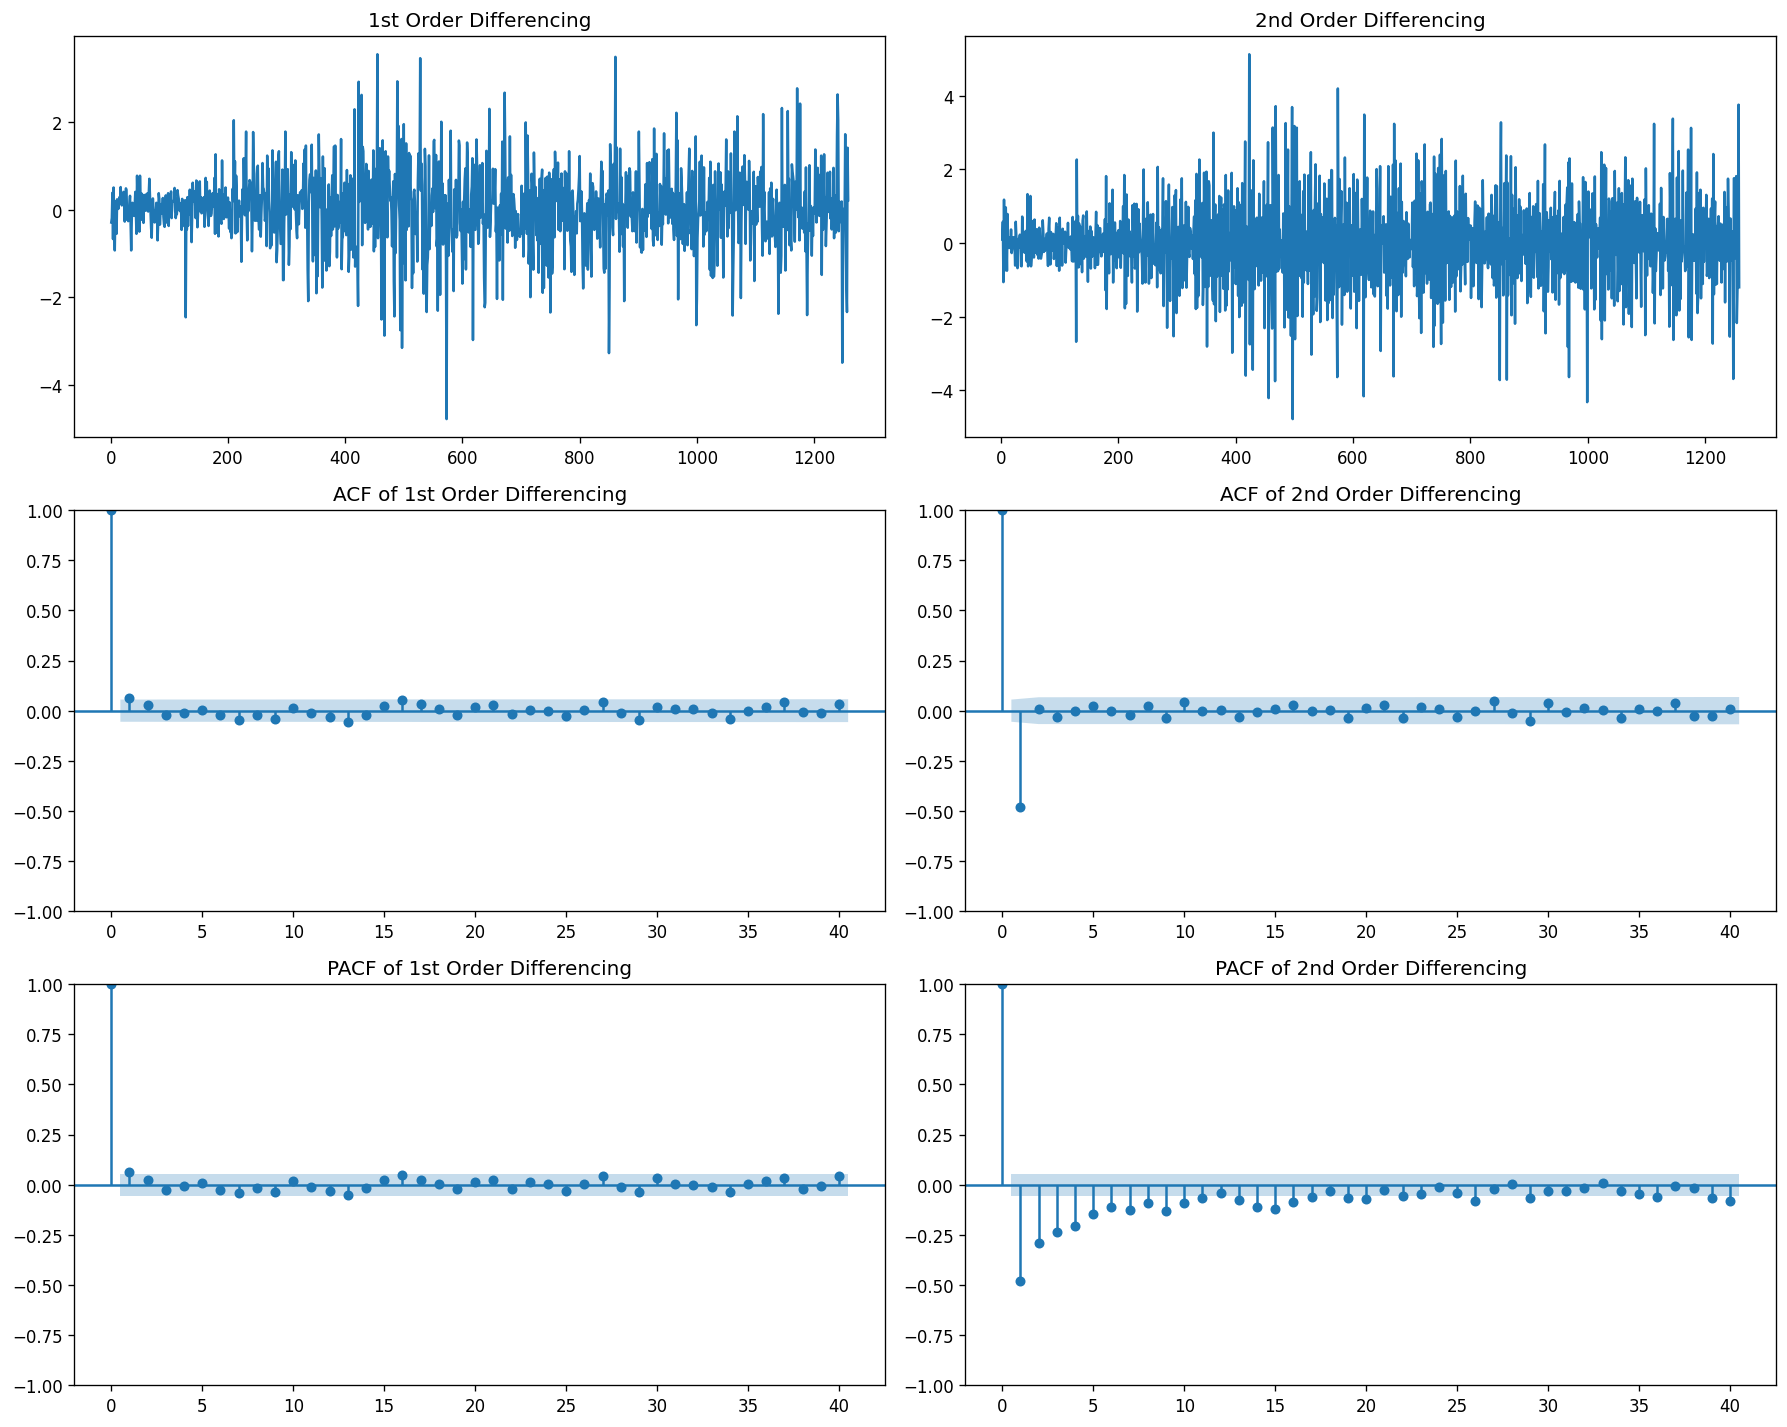

In [25]:
fig, axes = plt.subplots(3, 2, figsize=(15, 12), dpi=120)

#1st Order Differencing
axes[0, 0].plot(ALL_1.close.diff().dropna());axes[0, 0].set_title('1st Order Differencing')

plot_acf(ALL_1.close.diff().dropna(), ax=axes[1, 0], lags=40)
axes[1, 0].set_title('ACF of 1st Order Differencing')

plot_pacf(ALL_1.close.diff().dropna(), method='ywm',ax=axes[2, 0], lags=40)
axes[2, 0].set_title('PACF of 1st Order Differencing')


#2nd Order Differencing
axes[0, 1].plot(ALL_1.close.diff().diff().dropna());axes[0, 1].set_title('2nd Order Differencing')

plot_acf(ALL_1.close.diff().diff().dropna(), ax=axes[1, 1], lags=40)
axes[1, 1].set_title('ACF of 2nd Order Differencing')

plot_pacf(ALL_1.close.diff().diff().dropna(), method='ywm',ax=axes[2, 1], lags=40)
axes[2, 1].set_title('PACF of 2nd Order Differencing')



fig.tight_layout()
plt.show()


- From above plots, we can see that the time series reaches stationarity with one orders of differencing.

#### Dickey-Fuller test

- For 1st Order Differencing|

In [31]:
result_1 = adfuller(ALL_1.close.diff().dropna())
print('ADF Statistic: %f' % result_1[0])
print('p-value: %f' % result_1[1])

ADF Statistic: -33.199423
p-value: 0.000000


- For 2nd Order Differencing

In [32]:
result_2 = adfuller(ALL_1.close.diff().diff().dropna())
print('ADF Statistic: %f' % result_2[0])
print('p-value: %f' % result_2[1])

ADF Statistic: -13.149203
p-value: 0.000000


#### From Dickey_fuller test both difference are stationary

---

We randomly select q and p base on the graph above (acf and pacf)

In [33]:
model3 = ARIMA(ALL_1.close, order = (1,1,1))
model_fit3 = model3.fit()
print(model_fit3.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1259
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1601.880
Date:                Wed, 03 May 2023   AIC                           3209.761
Time:                        22:57:45   BIC                           3225.173
Sample:                             0   HQIC                          3215.553
                               - 1259                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2768      0.346      0.800      0.424      -0.402       0.955
ma.L1         -0.2107      0.352     -0.599      0.549      -0.901       0.479
sigma2         0.7474      0.021     36.346      0.0

In [37]:
residuals = pd.DataFrame(model_fit3.resid)

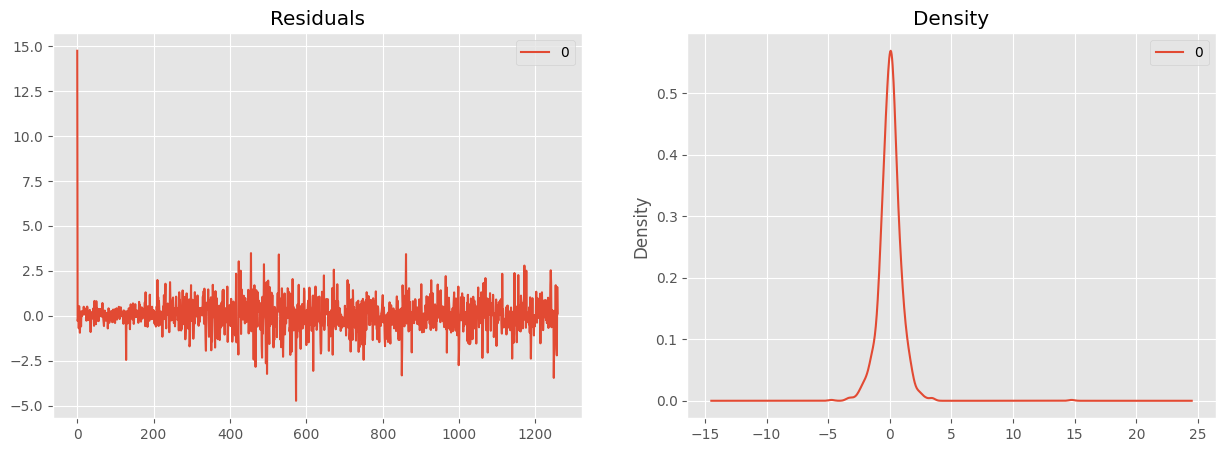

In [38]:
fig, ax = plt.subplots(1,2,figsize=(15, 5))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

### AIC

In [100]:
best_p = None
best_q = None
best_mse = np.inf

p_values = range(0, 6)
q_values = range(0, 6) 

warnings.filterwarnings("ignore")
 

for p in p_values:
    for q in q_values:
        try:
            model = ARIMA(ALL_1.close, order=(p, 1, q))
            model_fit = model.fit()
            mse = np.mean((model_fit.resid)**2)
            aic = model_fit.aic
            
            if mse <= best_mse:
                best_p = p
                best_q = q
                best_mse = mse
        except:
            continue

print("Best p:", best_p)
print("Best q:", best_q)

Best p: 5
Best q: 5


As q increases in the MA(q) model, the model becomes more flexible and able to capture more complex patterns in the data. This can result in a decrease in the MSE, as the model is better able to fit the data. However, as q continues to increase, the model may become overfit and start to capture noise rather than signal in the data. This can lead to an increase in the MSE.

## Auto arima to choose q and p

In [41]:
from pmdarima.arima import auto_arima

In [51]:
model = auto_arima(ALL_1.close, seasonal=True, suppress_warnings=True,
                   stepwise=True, trace=True, error_action="ignore", 
                   max_order=None, suppress_stderr=False, 
                   random_state=None, n_fits=50)

# Print the optimal ARIMA model order
print("Best ARIMA model order: (p, d, q) =", model.order)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3212.973, Time=0.92 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3212.261, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3208.962, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3209.245, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3211.684, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3210.192, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3210.554, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3211.797, Time=0.41 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3208.210, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=3209.380, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3209.761, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3208.511, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3211.060, Time=0.51 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 2.627 seconds
Best ARIMA model order

In [34]:
model3 = ARIMA(ALL_1.close, order = (1,1,0))
model_fit3 = model3.fit()
print(model_fit3.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1259
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1602.105
Date:                Wed, 03 May 2023   AIC                           3208.210
Time:                        19:23:33   BIC                           3218.484
Sample:                             0   HQIC                          3212.071
                               - 1259                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0659      0.025      2.680      0.007       0.018       0.114
sigma2         0.7476      0.021     36.365      0.000       0.707       0.788
Ljung-Box (L1) (Q):                   0.01   Jarque-

In [45]:
model4 = ARIMA(ALL_1.close, order = (5,1,5))
model_fit4 = model4.fit()
print(model_fit4.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1259
Model:                 ARIMA(5, 1, 5)   Log Likelihood               -1593.908
Date:                Wed, 03 May 2023   AIC                           3209.816
Time:                        23:05:58   BIC                           3266.326
Sample:                             0   HQIC                          3231.053
                               - 1259                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1798      0.040      4.498      0.000       0.101       0.258
ar.L2          0.5421      0.040     13.441      0.000       0.463       0.621
ar.L3          0.5046      0.029     17.324      0.0

## Section 3: Forecasting

### 4.1 Forecasting using ARIMA

In [59]:
from statsmodels.tsa.stattools import acf

In [60]:
train_size = 0.8  
train, test = train_test_split(ALL_1.deseason, train_size=train_size, shuffle=False)

In [61]:
# build model
model5 = ARIMA(train, order=(1, 1, 0), trend= 't')  
results = model5.fit()

fc = fitted.forecast(15, alpha=0.05)

In [62]:
fc= results.forecast(steps=len(test), alpha=0.05)


In [63]:
fc

1007    43.533946
1008    43.559647
1009    43.588825
1010    43.618202
1011    43.647591
          ...    
1254    50.789211
1255    50.818601
1256    50.847990
1257    50.877380
1258    50.906769
Name: predicted_mean, Length: 252, dtype: float64

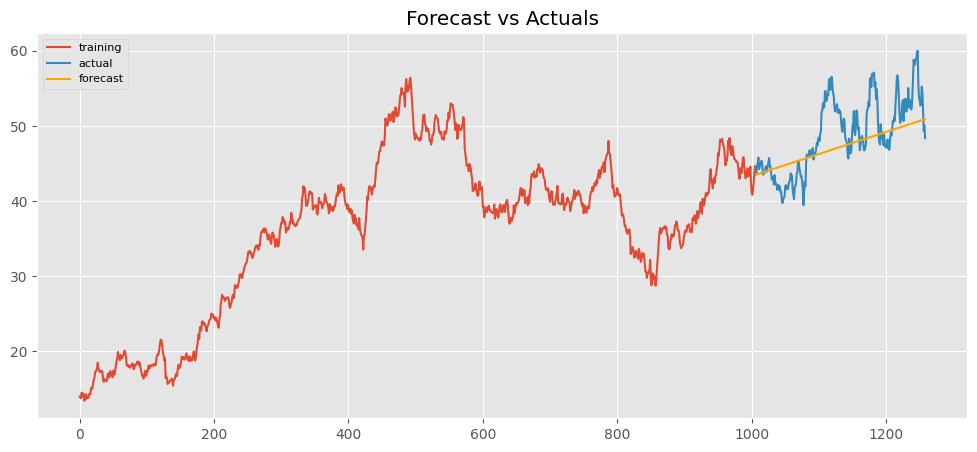

In [64]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc, label='forecast',color='orange')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### 4.2 Forecasting using LSTM

In [65]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout
import matplotlib.pyplot as plt

In [66]:
df = ALL_1
prices = df['close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = scaler.fit_transform(prices)
train_size = int(len(prices_scaled) * 0.8)
test_size = len(prices_scaled) - train_size
# Train and Test
train_data = prices_scaled[0:train_size, :]
test_data = prices_scaled[train_size:len(prices_scaled), :]


In [70]:
# Function to create dataset for LSTM
def create_dataset(dataset, time_steps=1):
    data_X, data_Y = [], []
    for i in range(len(dataset) - time_steps):
        data_X.append(dataset[i:(i + time_steps), 0])
        data_Y.append(dataset[i + time_steps, 0])
    return np.array(data_X), np.array(data_Y)


In [71]:
# Create training dataset For LSTM
time_steps = 20 
X_train, y_train = create_dataset(train_data, time_steps)
X_test, y_test = create_dataset(test_data, time_steps)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [73]:
# Define LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))


In [74]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 20, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


the learning rate of each weight based on the gradient of the loss function

LSTM implementation defaultly has activation="tanh", recurrent_activation="sigmoid",


In [75]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=10, batch_size=32)


Epoch 1/10
31/31 [==============================] - 6s 18ms/step - loss: 0.0361
Epoch 2/10
31/31 [==============================] - 1s 18ms/step - loss: 0.0067
Epoch 3/10
31/31 [==============================] - 1s 19ms/step - loss: 0.0050
Epoch 4/10
31/31 [==============================] - 1s 21ms/step - loss: 0.0051
Epoch 5/10
31/31 [==============================] - 1s 18ms/step - loss: 0.0045
Epoch 6/10
31/31 [==============================] - 1s 25ms/step - loss: 0.0044
Epoch 7/10
31/31 [==============================] - 1s 20ms/step - loss: 0.0044
Epoch 8/10
31/31 [==============================] - 1s 17ms/step - loss: 0.0043
Epoch 9/10
31/31 [==============================] - 1s 19ms/step - loss: 0.0041
Epoch 10/10
31/31 [==============================] - 1s 22ms/step - loss: 0.0040


In [76]:
# Make predictions
y_test_pred = model.predict(X_test)
y_test_pred = scaler.inverse_transform(y_test_pred)
y_test = y_test.reshape(-1,1)
y_test = scaler.inverse_transform(y_test)


8/8 [==============================] - 1s 6ms/step


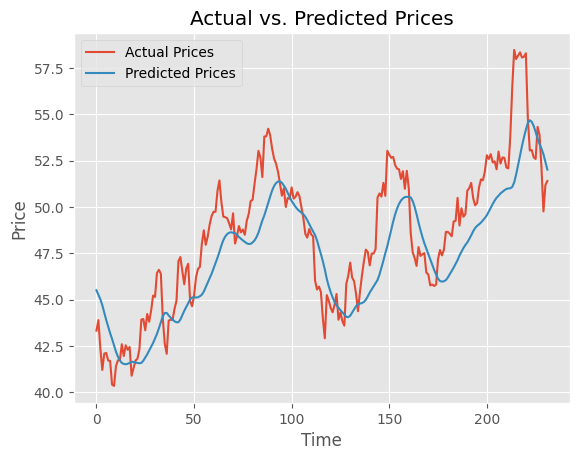

In [77]:
# Plot actual vs predicted stock prices
plt.plot(y_test, label='Actual Prices')
plt.plot(y_test_pred, label='Predicted Prices')
plt.title('Actual vs. Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

## Section 5: ~